# Using JAX for faster sampling

(c) Thomas Wiecki, 2020

*Note: These samplers are still experimental.*

Using the new Theano JAX linker that Brandon Willard has developed, we can compile PyMC3 models to JAX without any change to the PyMC3 code base or any user-level code changes. The way this works is that we take our Theano graph built by PyMC3 and then translate it to JAX primitives. 

Using our Python samplers, this is still a bit slower than the C-code generated by default Theano.

However, things get really interesting when we also express our samplers in JAX. Here we have used the JAX samplers by NumPyro or TFP. This combining of the samplers was done by [Junpeng Lao](https://twitter.com/junpenglao). 

The reason this is so much faster is that while before in PyMC3, only the logp evaluation was compiled while the samplers where still coded in Python, so for every loop we went back from C to Python. With this approach, the model *and* the sampler are JIT-compiled by JAX and there is no more Python overhead during the whole sampling run. This way we also get sampling on GPUs or TPUs for free.

This NB requires the master of [Theano-PyMC](https://github.com/pymc-devs/Theano-PyMC), the [pymc3jax branch of PyMC3](https://github.com/pymc-devs/pymc3/tree/pymc3jax), as well as JAX, TFP-nightly and numpyro.

This is all still highly experimental but extremely promising and just plain amazing.

As an example we'll use the classic Radon hierarchical model. Note that this model is still very small, I would expect much more massive speed-ups with larger models.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import pymc3.sampling_jax
import theano

print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v3.9.3


/Users/twiecki/projects/pymc/pymc3/sampling_jax.py:20: UserWarning: This module is still highly experimental.
  warnings.warn("This module is still highly experimental.")


In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

In [3]:
data = pd.read_csv(pm.get_data("radon.csv"))
data["log_radon"] = data["log_radon"].astype(theano.config.floatX)
county_names = data.county.unique()
county_idx = data.county_code.values.astype("int32")

n_counties = len(data.county.unique())

Unchanged PyMC3 model specification:

In [4]:
with pm.Model() as hierarchical_model:
    # Hyperpriors for group nodes
    mu_a = pm.Normal("mu_a", mu=0.0, sigma=100.0)
    sigma_a = pm.HalfNormal("sigma_a", 5.0)
    mu_b = pm.Normal("mu_b", mu=0.0, sigma=100.0)
    sigma_b = pm.HalfNormal("sigma_b", 5.0)

    # Intercept for each county, distributed around group mean mu_a
    # Above we just set mu and sd to a fixed value while here we
    # plug in a common group distribution for all a and b (which are
    # vectors of length n_counties).
    a = pm.Normal("a", mu=mu_a, sigma=sigma_a, shape=n_counties)
    # Intercept for each county, distributed around group mean mu_a
    b = pm.Normal("b", mu=mu_b, sigma=sigma_b, shape=n_counties)

    # Model error
    eps = pm.HalfCauchy("eps", 5.0)

    radon_est = a[county_idx] + b[county_idx] * data.floor.values

    # Data likelihood
    radon_like = pm.Normal("radon_like", mu=radon_est, sigma=eps, observed=data.log_radon)

## Sampling using our old Python NUTS sampler

In [5]:
%%time
with hierarchical_model:
    hierarchical_trace = pm.sample(
        2000, tune=2000, target_accept=0.9, compute_convergence_checks=False
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps, b, a, sigma_b, mu_b, sigma_a, mu_a]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 53 seconds.
There were 1326 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7792227822549999, but should be close to 0.9. Try to increase the number of tuning steps.
There were 169 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7767119949826401, but should be close to 0.9. Try to increase the number of tuning steps.


CPU times: user 6.01 s, sys: 761 ms, total: 6.77 s
Wall time: 57 s


## Sampling using JAX TFP NUTS sampler

In [6]:
%%time
# Inference button (TM)!
with hierarchical_model:
    hierarchical_trace_jax = pm.sampling_jax.sample_numpyro_nuts(2000, tune=2000, target_accept=0.9)

Compiling...


/Users/twiecki/miniconda3/envs/pymc3theano/lib/python3.8/site-packages/jax/interpreters/xla.py:624: UserWarning: The jitted function _sample includes a pmap. Using jit-of-pmap can lead to inefficient data movement, as the outer jit does not preserve sharded data representations and instead collects input and output arrays onto a single device. Consider removing the outer jit unless you know what you're doing. See https://github.com/google/jax/issues/2926.
  warn(f"The jitted function {fun.__name__} includes a pmap. Using "


Compilation + sampling time =  0 days 00:00:24.352507
CPU times: user 30.6 s, sys: 1.64 s, total: 32.2 s
Wall time: 32.9 s


In [7]:
print(f"Speed-up = {180 / 24}x")

Speed-up = 7.5x


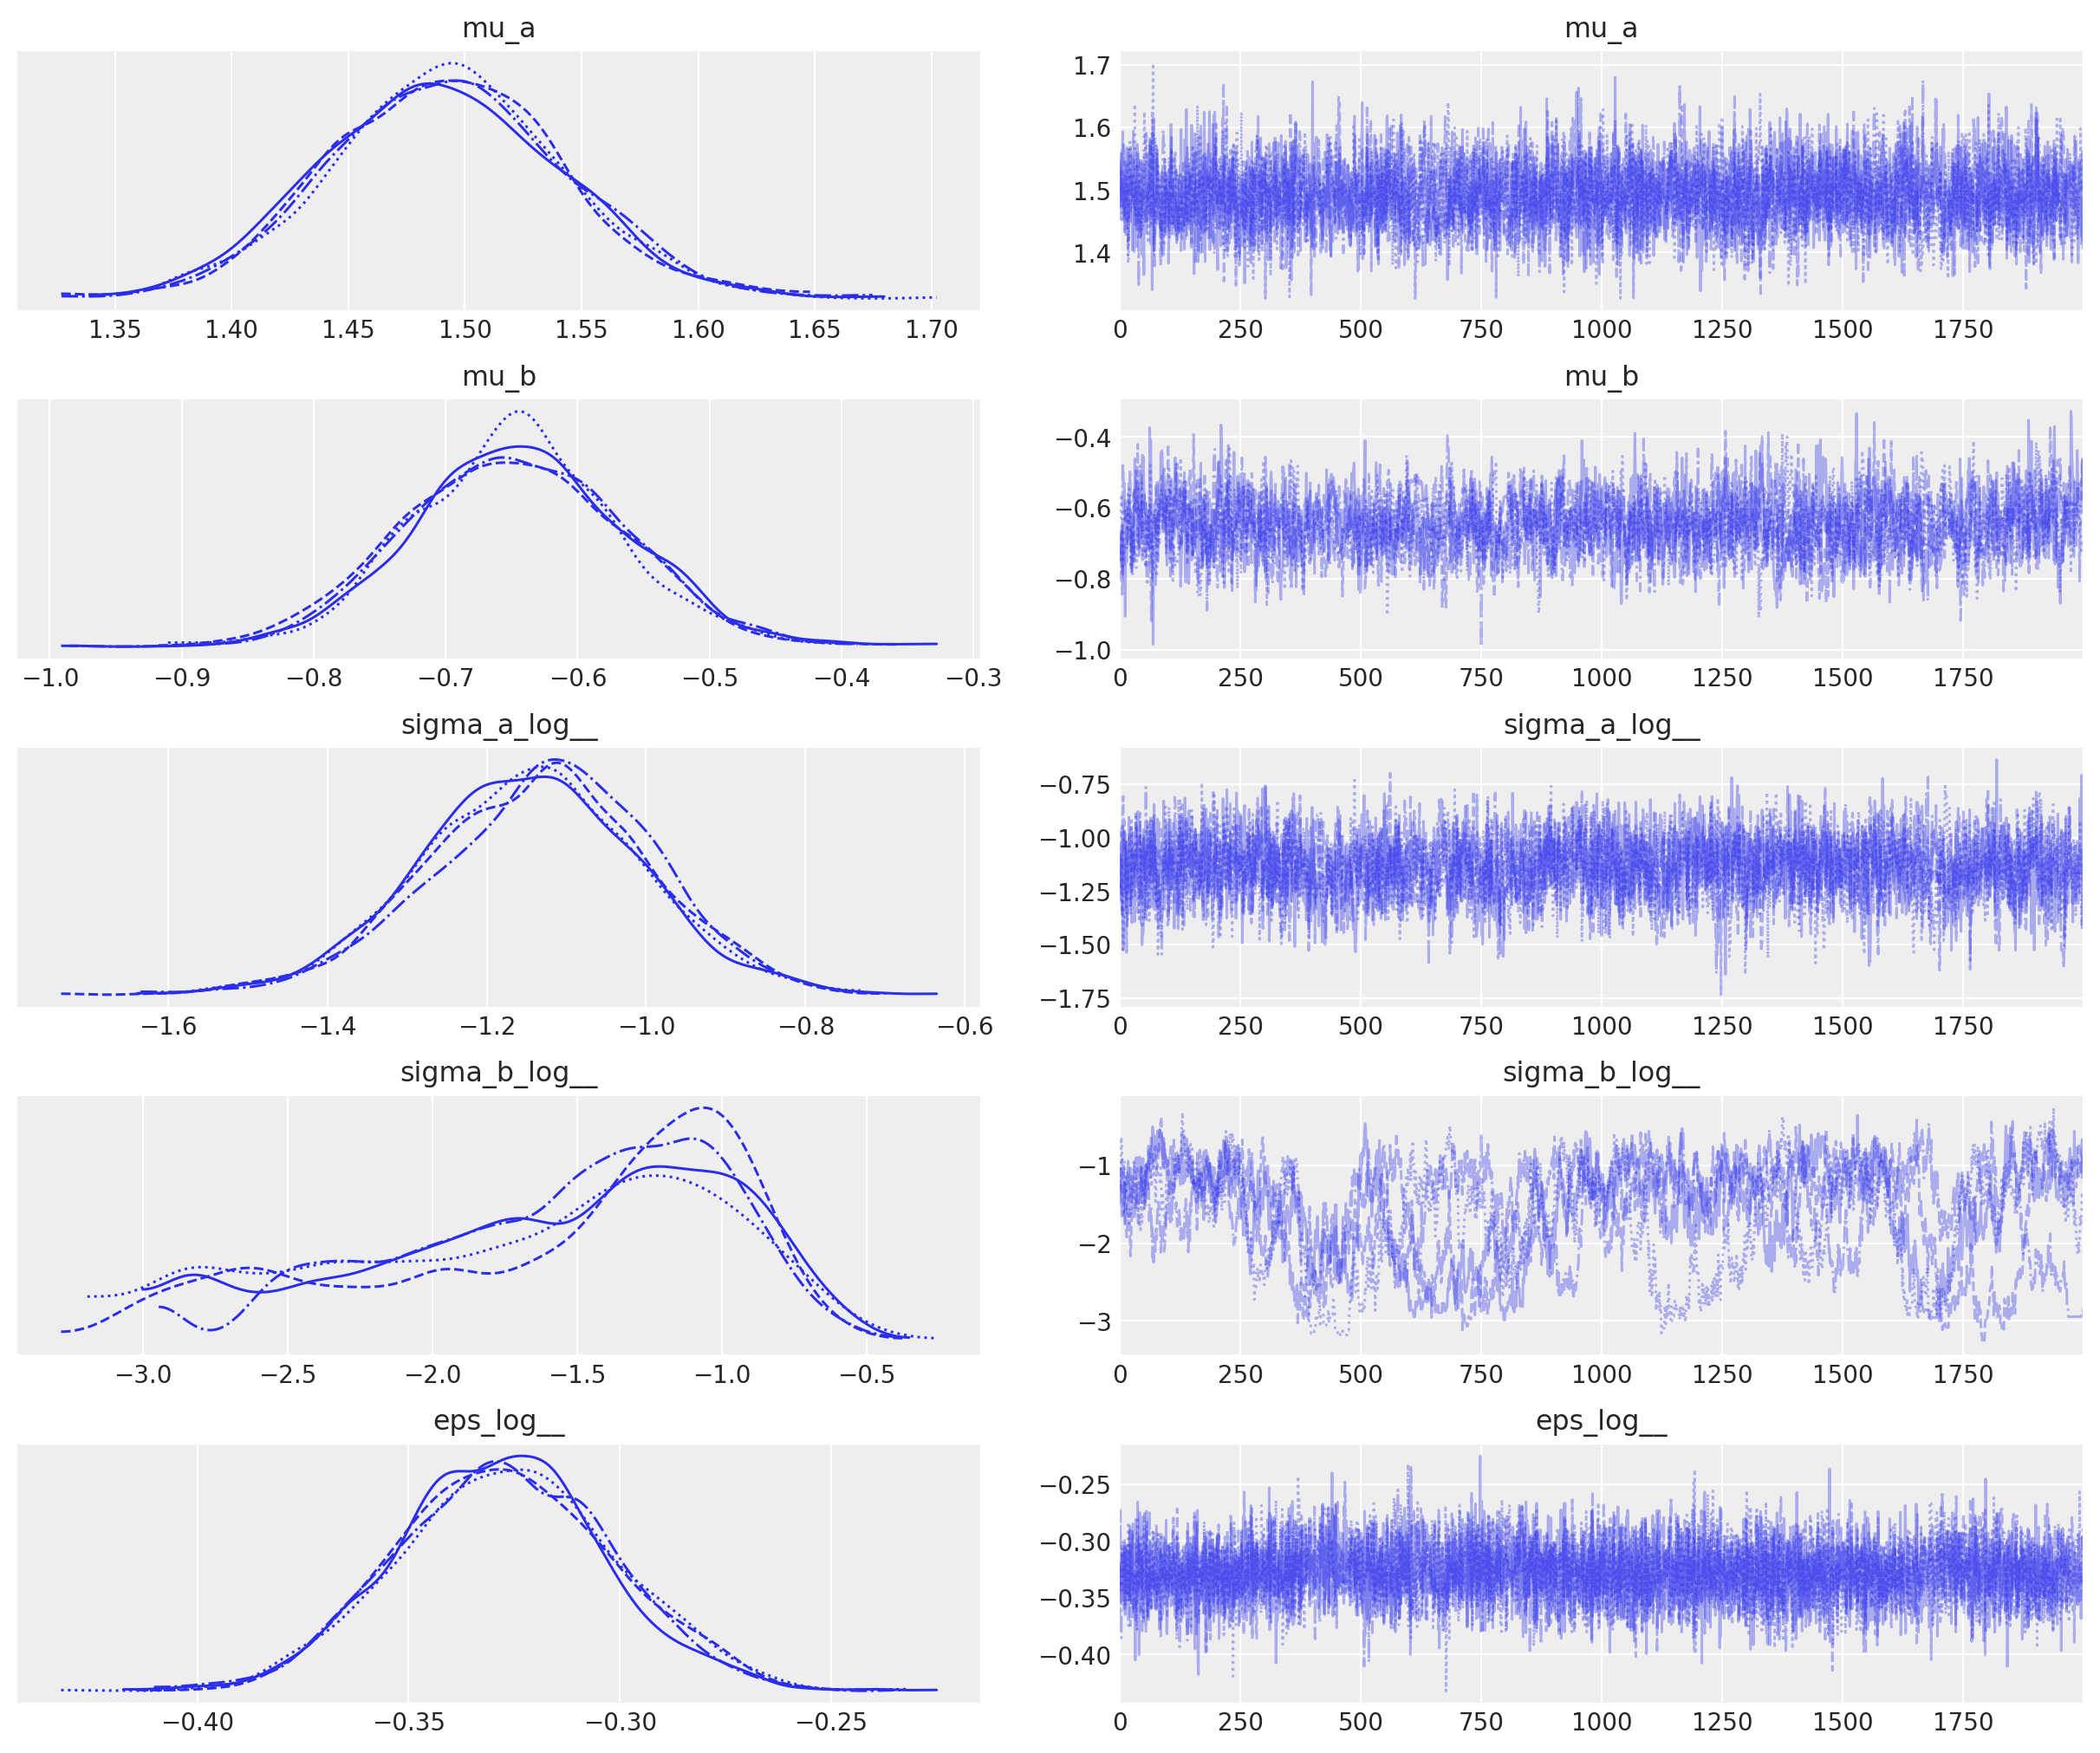

In [8]:
pm.traceplot(
    hierarchical_trace_jax,
    var_names=["mu_a", "mu_b", "sigma_a_log__", "sigma_b_log__", "eps_log__"],
);

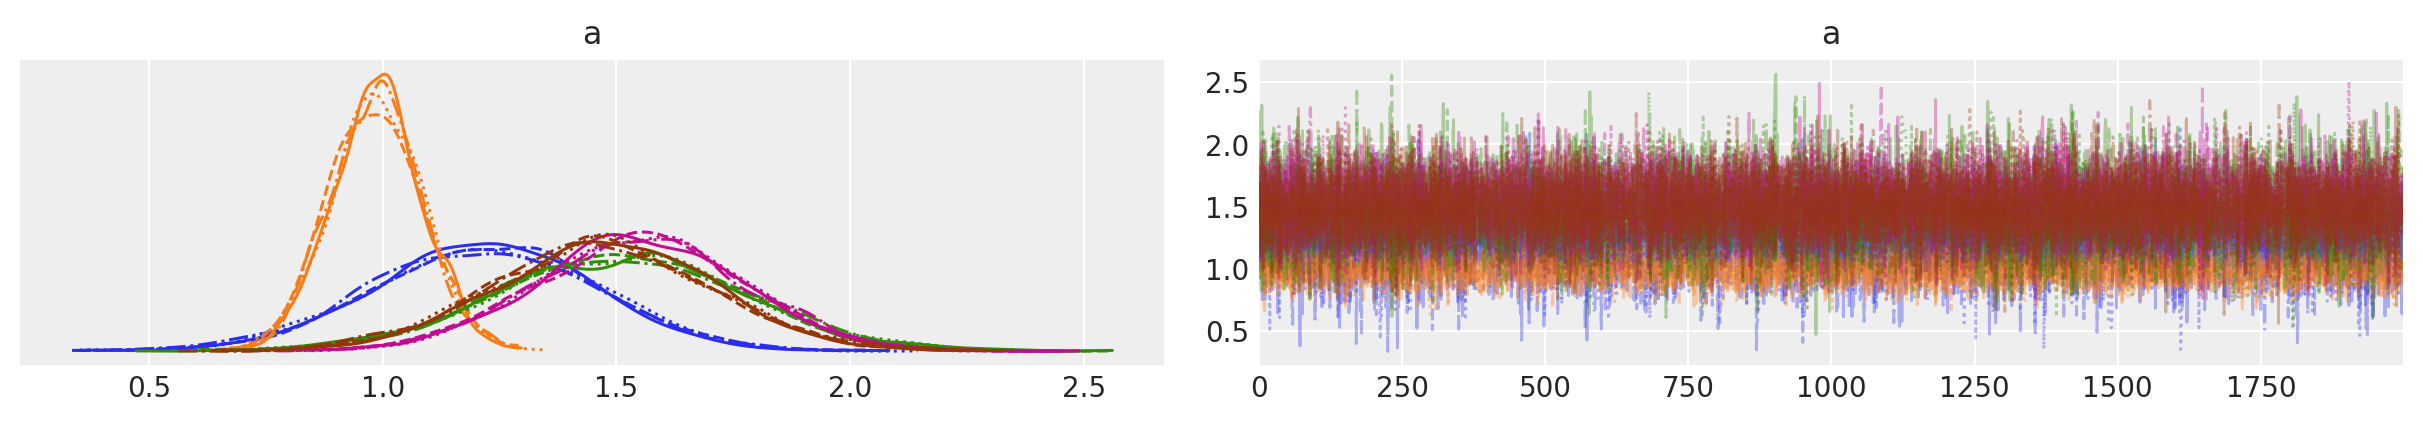

In [9]:
pm.traceplot(hierarchical_trace_jax, var_names=["a"], coords={"a_dim_0": range(5)});

In [10]:
%load_ext watermark
%watermark -n -u -v -iv -w

arviz    0.10.0
pandas   1.1.2
numpy    1.19.1
json     2.0.9
pymc3    3.9.3
theano   1.0.5
autopep8 1.5.4
last updated: Mon Nov 23 2020 

CPython 3.8.5
IPython 7.18.1
watermark 2.0.2
